# Building a Rainfall Prediction Pipeline
### Objectives

* Explore and perform feature engineering on a dataset that comprises about 10 years of daily weather observations.
* Build a classification pipeline using different classification models and optimize it using grid search cross validation.
* Evaluate the models by interpreting various performance metrics and visualizations.

### About the dataset
This dataset comprises about 10 years of daily weather observations from numerous locations across Australia.
RainTomorrow is the target variable to predict. It answers the crucial question: will it rain the next day? (Yes or No).

The dataset contains observations of weather metrics for each day from 2008 to 2017, and includes the following fields:

| Field         | Description                                           | Unit            | Type   |
| :------------ | :---------------------------------------------------- | :-------------- | :----- |
| Date          | Date of the Observation in YYYY-MM-DD                 | Date            | object |
| Location      | Location of the Observation                           | Location        | object |
| MinTemp       | Minimum temperature                                   | Celsius         | float  |
| MaxTemp       | Maximum temperature                                   | Celsius         | float  |
| Rainfall      | Amount of rainfall                                    | Millimeters     | float  |
| Evaporation   | Amount of evaporation                                 | Millimeters     | float  |
| Sunshine      | Amount of bright sunshine                             | hours           | float  |
| WindGustDir   | Direction of the strongest gust                       | Compass Points  | object |
| WindGustSpeed | Speed of the strongest gust                           | Kilometers/Hour | object |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9am  | Compass Points  | object |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3pm  | Compass Points  | object |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9am      | Kilometers/Hour | float  |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3pm      | Kilometers/Hour | float  |
| Humidity9am   | Humidity at 9am                                       | Percent         | float  |
| Humidity3pm   | Humidity at 3pm                                       | Percent         | float  |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9am | Hectopascal     | float  |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascal     | float  |
| Cloud9am      | Fraction of the sky obscured by cloud at 9am          | Eights          | float  |
| Cloud3pm      | Fraction of the sky obscured by cloud at 3pm          | Eights          | float  |
| Temp9am       | Temperature at 9am                                    | Celsius         | float  |
| Temp3pm       | Temperature at 3pm                                    | Celsius         | float  |
| RainToday     | If there was at least 1mm of rain today               | Yes/No          | object |
| RainTomorrow  | If there is at least 1mm of rain tomorrow             | Yes/No          | object |

# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
# import seaborn as sns

# Load data

In [2]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No


# Data Pre-processing

In [3]:
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

Sunshine and cloud cover seem like important features, but they have a lot of missing values, far too many to impute their missing values.

### Drop all rows with missing values
To try to keep things simple we'll drop rows with missing values and see what's left

In [4]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

Since we still have 56k observations left after dropping missing values, we may not need to impute any missing values.  
Let's see how we do.

In [5]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

### Data leakage considerations
Data leakage occurs when a model is trained on information that would not be available at the time of prediction in a real-world scenario. In this dataset, a potential source of leakage is the `RainToday` feature. Although it may seem like a useful predictor, it is often recorded close to the end of the day — possibly just minutes before midnight. Since rainfall is likely to continue into the next day, this feature could unintentionally provide hints about RainTomorrow, the target variable. This leads to an unrealistic boost in performance metrics. To avoid this leakage and ensure fair evaluation, it’s recommended to drop `RainToday` during training.

In [6]:
df.drop(columns=['RainToday'], inplace=True)

### Location selection
Using all of the locations requires a more complex model as it needs to adapt to local weather patterns.  
Let's see how many observations we have for each location, and see if we can reduce our attention to a smaller region.

You could do some research to group cities in the `Location` column by distance, which I've done for you behind the scenes.  
I found that Watsonia is only 15 km from Melbourne, and the Melbourne Airport is only 18 km from Melbourne.  
Let's group these three locations together and use only their weather data to build our localized prediction model.  
Because there might still be some slight variations in the weather patterns we'll keep `Location` as a categorical variable.



In [7]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

We still have 7557 records, which should be enough to build a reasonably good model.  

### Extracting a seasonality feature
We expect the weather patterns to be seasonal, having different predictablitiy levels in winter and summer for example.  
There may be some variation with `Year` as well, but we'll leave that out for now.
Let's engineer a `Season` feature from `Date` and drop `Date` afterward, since it is most likely less informative than season. 
An easy way to do this is to define a function that assigns seasons to given months, then use that function to transform the `Date` column.

In [8]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

In [9]:
# Map the dates to seasons and drop the Date column
df['Date'] = pd.to_datetime(df['Date'])
# Apply the function to the 'Date' column
df['Season'] = df['Date'].apply(date_to_season)
df=df.drop(columns=['Date'])
df.head(3)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,55.0,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,50.0,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,51.0,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,Summer


## Split data into training and testing sets and specify stratified cross validation

In [10]:
# Define the feature and target dataframes
X = df.drop(columns='RainTomorrow', axis=1)
y = df['RainTomorrow']

### Addressing class imbalance

In [11]:
y.value_counts()

RainTomorrow
No     5766
Yes    1791
Name: count, dtype: int64

We notice that the target variable is imbalanced, therefore, we will ensure target stratifaction when splitting the data into training and testing sets.

In [12]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Select a cross-validation method, ensuring target stratification during validation
cv = StratifiedKFold(n_splits=5, shuffle=True)

## Building the pipeline

### Define preprocessing transformers for numerical and categorical features and create a pipeline

In [13]:
# Detect numerical and categorical features
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define separate transformers for both feature types and combine them into a single preprocessing transformer
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())]) # Scale the numeric features
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]) # One-hot encode the categoricals 

# Combine the transformers into a single preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Initial pipeline with only the preprocessor and a placeholder for the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', 'passthrough')  # 'passthrough' is a placeholder, we will set the model shortly
])

### Define a function to print classification results in one call

In [14]:
def evaluate_model(grid_search, X_test, y_test, scoring='accuracy'):
    """
    Evaluates the model from the grid search on the test set and prints relevant metrics.
    Allows flexible scoring choice ('recall' or 'accuracy').

    Parameters:
    - grid_search: The GridSearchCV object that has been fit to the training data.
    - X_test: The test set features.
    - y_test: The actual test set labels.
    - scoring: Scoring metric used for grid search ('recall' or 'accuracy').
    """
    
    # Print best parameters and scores
    print(f"🔍 Best Parameters Found: {grid_search.best_params_}")
    print(f"📊 Best Cross-Validation {scoring.capitalize()}: {grid_search.best_score_:.2f}")

    # Evaluate on test set
    test_score = grid_search.score(X_test, y_test)
    print(f"🧪 Test Set {scoring.capitalize()} Score: {test_score:.2f}")

    # Predictions on test data
    y_pred = grid_search.predict(X_test)

    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()


## Random Forest Classifier

In [15]:
# Define a parameter grid to use in a cross validation grid search model optimizer
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

pipeline.set_params(classifier=RandomForestClassifier(class_weight='balanced', random_state=42))

# Instantiate and fit GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)  
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

#### Classification results (best parameters, best crossvalidation and test scores, classification report, and confusion matrix)

🔍 Best Parameters Found: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
📊 Best Cross-Validation Accuracy: 0.85
🧪 Test Set Accuracy Score: 0.85

📋 Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.95      0.90      1154
         Yes       0.75      0.53      0.62       358

    accuracy                           0.85      1512
   macro avg       0.81      0.74      0.76      1512
weighted avg       0.84      0.85      0.84      1512



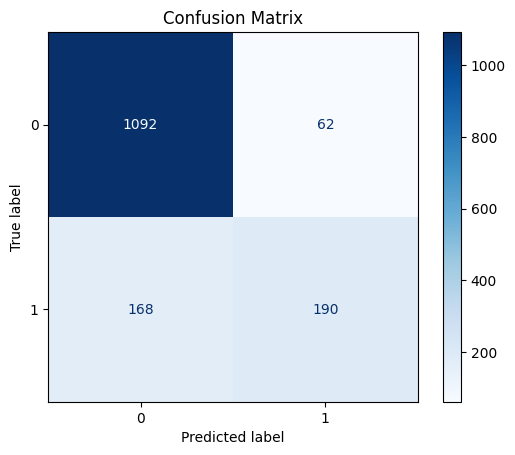

In [16]:
evaluate_model(grid_search, X_test, y_test, scoring='accuracy')

The Random Forest Classifier achieves an accuracy of 85%. However, it demonstrates high precision but low recall. This indicates that the model tends to predict rain only when it is highly confident, leading to fewer false alarms (high precision) but also missing many actual rain events (low recall). In other words, it frequently predicts no rain when rain is indeed occurring, which could be problematic in applications where failing to predict a rain event is costly. In such cases, we may want to prioritize improving recall, even if it means tolerating more false alarms. To achieve this, we can retrain the model by adjusting the scoring metric to 'recall' during training, encouraging the model to capture more rainy days at the expense of some additional false positives.

## Precision-Recall trade-off, improving recall for the RF classifier

In [17]:
# Define a custom scorer that treats 'Yes' as the positive class
recall_scorer = make_scorer(recall_score, pos_label='Yes')

# Instantiate and fit GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=recall_scorer, verbose=2)  
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.8s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.8s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.8s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.8s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.8s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=Yes),
             verbose=2)

🔍 Best Parameters Found: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
📊 Best Cross-Validation Recall: 0.70
🧪 Test Set Recall Score: 0.71

📋 Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.84      0.87      1154
         Yes       0.58      0.71      0.64       358

    accuracy                           0.81      1512
   macro avg       0.74      0.77      0.75      1512
weighted avg       0.83      0.81      0.81      1512



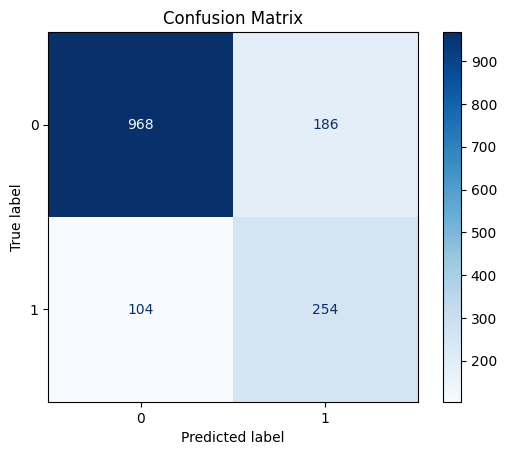

In [18]:
evaluate_model(grid_search, X_test, y_test, scoring='recall')

By prioritizing recall, the model will capture more positive cases (rainy days) while accepting an increase in false alarms. The choice between precision and recall really depends on the specific problem domain and requirements, so it's important to consider the trade-offs carefully based on the context.

#### Extract the feature importances
We will define a function for desplying feature importance to reuse with other models

In [19]:
def plot_top_feature_importances(grid_search, numeric_features, categorical_features, N=20, title='Top Features'):
    """
    Plots the top N most important features from a trained pipeline in grid_search.
    
    Parameters:
        grid_search: Trained GridSearchCV or similar object with a pipeline.
        numeric_features: List of numeric feature names.
        categorical_features: List of categorical feature names.
        N: Number of top features to display.
        title: Title for the plot.
    """
    # Get the best estimator's classifier
    classifier = grid_search.best_estimator_['classifier']
    
    # Ensure the classifier has feature_importances_ attribute
    if not hasattr(classifier, 'feature_importances_'):
        raise AttributeError("The classifier does not support feature_importances_ (e.g., not a tree-based model).")
    
    # Get the feature importances
    feature_importances = classifier.feature_importances_
    
    # Get the transformed categorical feature names
    cat_transformer = grid_search.best_estimator_['preprocessor'].named_transformers_['cat']
    onehot = cat_transformer.named_steps['onehot']
    cat_feature_names = list(onehot.get_feature_names_out(categorical_features))
    
    # Combine all feature names
    feature_names = numeric_features + cat_feature_names

    # Create DataFrame of features and their importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    top_features = importance_df.head(N)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f'{title} (Top {N})')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

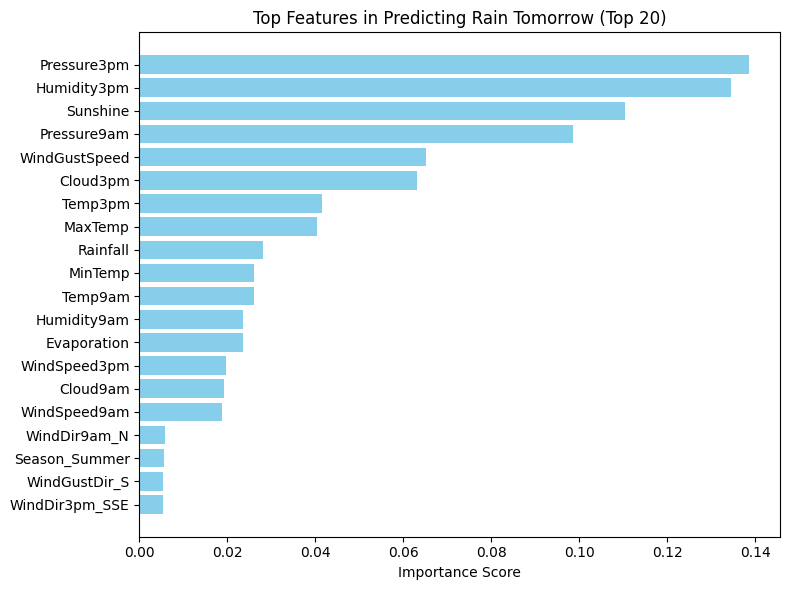

In [20]:
plot_top_feature_importances(grid_search, numeric_features, categorical_features, N=20, title='Top Features in Predicting Rain Tomorrow')

## Logistic Regression

In [21]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

# update the model's estimator to use the new pipeline
grid_search.estimator = pipeline
grid_search.scoring = 'accuracy'
grid_search.param_grid = param_grid

# Fit the updated pipeline with LogisticRegression
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

🔍 Best Parameters Found: {'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
📊 Best Cross-Validation Accuracy: 0.83
🧪 Test Set Accuracy Score: 0.83

📋 Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.68      0.51      0.58       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



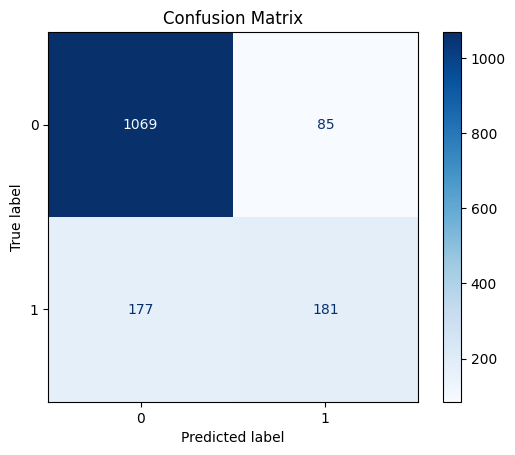

In [22]:
evaluate_model(grid_search, X_test, y_test)

## Conclusion

Both the Random Forest Classifier and Logistic Regression achieved comparable overall performance, with the Random Forest showing a slight edge in terms of accuracy—85% compared to 83% for Logistic Regression. However, accuracy alone does not capture the full picture, especially in situations where the costs of false negatives and false positives are not equal.

As demonstrated, there is a trade-off between precision and recall that must be carefully considered based on the specific goals and constraints of the problem domain. For instance, in scenarios such as weather prediction or medical diagnostics, missing a positive case (e.g., failing to predict rain or diagnose a disease) can have significant consequences. In such cases, optimizing for recall—even at the expense of a few more false alarms—might be preferable.

Random Forests tend to be more conservative in their positive predictions, leading to higher precision but lower recall by default. Logistic Regression, on the other hand, may be more balanced depending on threshold settings. Understanding this trade-off enables more informed model selection and hyperparameter tuning strategies.

Ultimately, choosing the right model and evaluation metric should be guided by the specific requirements of the application—whether minimizing false alarms, catching as many positive cases as possible, or balancing both.